# Hello world

## Quickest introduction to Nipype workflows 

![Nipype architecture](https://raw.github.com/satra/intro2nipype/master/images/arch.png)

- [Existing documentation](http://nipype.readthedocs.io/en/latest/)

- [Comprehensive tutorials](https://miykael.github.io/nipype_tutorial/)

- [Visualizing the evolution of Nipype](https://www.youtube.com/watch?v=cofpD1lhmKU)

#### Import a few things from nipype

In [1]:
import os
from nipype import Workflow, Node, Function

Creating Workflow with one Node that adds two numbers

In [2]:
def sum(a, b):
    return a + b

wf = Workflow('hello')

adder = Node(Function(input_names=['a', 'b'],
                      output_names=['sum'],
                      function=sum), 
             name='a_plus_b')

adder.inputs.a = 1
adder.inputs.b = 3

wf.add_nodes([adder])

wf.base_dir = os.getcwd()

eg = wf.run()

eg.nodes()[0].result.outputs

170829-12:57:38,977 workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging']
170829-12:57:39,26 workflow INFO:
	 Running serially.
170829-12:57:39,29 workflow INFO:
	 Executing node a_plus_b in dir: /opt/tutorial/notebooks/hello/a_plus_b



sum = 4

Creating a second node and connecting to the ``hello`` Workflow 

In [3]:
def concat(a, b):
    return [a, b]


concater = Node(Function(input_names=['a', 'b'],
                         output_names=['some_list'],
                         function=concat), 
                name='concat_a_b')

wf.connect(adder, 'sum', concater, 'a')
concater.inputs.b = 3

eg = wf.run()
print(eg.nodes())

170829-12:57:40,270 workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging']
170829-12:57:40,330 workflow INFO:
	 Running serially.
170829-12:57:40,332 workflow INFO:
	 Executing node a_plus_b in dir: /opt/tutorial/notebooks/hello/a_plus_b
170829-12:57:40,415 workflow INFO:
	 Executing node concat_a_b in dir: /opt/tutorial/notebooks/hello/concat_a_b
[hello.a_plus_b, hello.concat_a_b]


And we can check results of our Workflow, we should see a list:

In [4]:
eg.nodes()[-1].result.outputs


some_list = [4, 3]

We will try to add additional Node that adds one:

In [5]:
def plus_one(a):
    print("PLUS ONE, a = {}".format(a))
    return a + 1

plusone = Node(Function(input_names=['a'],
                        output_names=['out'],
                        function=plus_one), 
               name='add_1')

wf.connect(concater, 'some_list', plusone, 'a')

eg = wf.run()
print(eg.nodes())

170829-12:57:42,994 workflow INFO:
	 Workflow hello settings: ['check', 'execution', 'logging']
170829-12:57:43,42 workflow INFO:
	 Running serially.
170829-12:57:43,44 workflow INFO:
	 Executing node a_plus_b in dir: /opt/tutorial/notebooks/hello/a_plus_b
170829-12:57:43,66 workflow INFO:
170829-12:57:43,79 workflow INFO:
	 Executing node concat_a_b in dir: /opt/tutorial/notebooks/hello/concat_a_b
170829-12:57:43,150 workflow INFO:
	 Executing node add_1 in dir: /opt/tutorial/notebooks/hello/add_1
PLUS ONE, a = [4, 3]
170829-12:57:43,196 workflow ERROR:
	 ['Node add_1 failed to run on host db3db9bfe867.']
170829-12:57:43,200 workflow INFO:
	 Saving crash info to /opt/tutorial/notebooks/crash-20170829-125743-neuro-add_1-8b4dad6e-0d61-4d9d-8870-45eea5011a06.pklz
170829-12:57:43,202 workflow INFO:
	 Traceback (most recent call last):
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/linear.py", line 43, in run
    node.run(updatehash=updatehash)
  File "/o

RuntimeError: Workflow did not execute cleanly. Check log for details

This time the workflow didn't execute cleanly and we got an error. We can use ``nipypecli`` to read the crashfile (note, that if you have multiple crashfiles in the directory you'll have to provide a full name):

In [6]:
!LC_ALL= nipypecli crash crash*



File: /opt/tutorial/notebooks/crash-20170829-125743-neuro-add_1-8b4dad6e-0d61-4d9d-8870-45eea5011a06.pklz
Node: hello.add_1
Working directory: /opt/tutorial/notebooks/hello/add_1


Node inputs:

a = [4, 3]
function_str = def plus_one(a):
    print("PLUS ONE, a = {}".format(a))
    return a + 1

ignore_exception = False



Traceback: 
Traceback (most recent call last):
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/plugins/linear.py", line 43, in run
    node.run(updatehash=updatehash)
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 372, in run
    self._run_interface()
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 482, in _run_interface
    self._result = self._run_command(execute)
  File "/opt/conda/envs/neuro/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 613, in _run_command
    result = self._interface.run()
  File "/opt/conda/envs/neu

It clearly shows the problematic Node and the its input. We tried to add an integer to a list, this operation is not allowed in Python. 

Let's try using MapNode

In [7]:
from nipype import MapNode

plusone = MapNode(Function(input_names=['a'],
                           output_names=['out'],
                           function=plus_one), 
                  iterfield=['a'],
                  name='add_1')

wf = Workflow('hello_mapnode')

adder = Node(Function(input_names=['a', 'b'],
                      output_names=['sum'],
                      function=sum), 
             name='a_plus_b')

adder.inputs.a = 1
adder.inputs.b = 3
wf.connect(adder, 'sum', concater, 'a')
concater.inputs.b = 3

wf.connect(concater, 'some_list', plusone, 'a')

wf.base_dir = os.getcwd()

eg = wf.run()
print(eg.nodes())

170829-12:57:54,95 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170829-12:57:54,172 workflow INFO:
	 Running serially.
170829-12:57:54,176 workflow INFO:
	 Executing node a_plus_b in dir: /opt/tutorial/notebooks/hello_mapnode/a_plus_b
170829-12:57:54,190 workflow INFO:
170829-12:57:54,202 workflow INFO:
	 Executing node concat_a_b in dir: /opt/tutorial/notebooks/hello/concat_a_b
170829-12:57:54,218 workflow INFO:
170829-12:57:54,231 workflow INFO:
	 Executing node add_1 in dir: /opt/tutorial/notebooks/hello_mapnode/add_1
[hello_mapnode.a_plus_b, hello.concat_a_b, hello_mapnode.add_1]


Now the workflow finished without problems, let's see the results from ``hello.add_1``:

In [8]:
print(eg.nodes()[2].result.outputs)

Bunch(out=[5, 4])


And now we will run example with ``iterables``:

In [9]:
adder.iterables = ('a', [1, 2])
adder.inputs.b = 2

eg = wf.run()
print(eg.nodes())

170829-12:57:56,972 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170829-12:57:57,24 workflow INFO:
	 Running serially.
170829-12:57:57,31 workflow INFO:
	 Executing node a_plus_b.aI.a1 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/a_plus_b
170829-12:57:57,101 workflow INFO:
170829-12:57:57,118 workflow INFO:
	 Executing node concat_a_b.a1 in dir: /opt/tutorial/notebooks/hello/_a_2/concat_a_b
170829-12:57:57,135 workflow INFO:
170829-12:57:57,153 workflow INFO:
	 Executing node add_1.a1 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/add_1
170829-12:57:57,175 workflow INFO:
	 Executing node a_plus_b.aI.a0 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_1/a_plus_b
170829-12:57:57,190 workflow INFO:
170829-12:57:57,202 workflow INFO:
	 Executing node concat_a_b.a0 in dir: /opt/tutorial/notebooks/hello/_a_1/concat_a_b
170829-12:57:57,251 workflow INFO:
170829-12:57:57,263 workflow INFO:
	 Executing node add_1.a0 in dir: /opt/tutorial/notebook

Now we have 6 nodes, we can check results for `` hello.add_1.a1``

In [10]:
eg.nodes()[5].result.outputs

Bunch(out=[5, 4])

In [11]:
wf.write_graph(graph2use='exec')

170829-12:58:00,631 workflow INFO:
	 Generated workflow graph: /opt/tutorial/notebooks/hello_mapnode/graph.dot.png (graph2use=exec, simple_form=True).


'/opt/tutorial/notebooks/hello_mapnode/graph.dot.png'

In [12]:
from IPython.display import Image

We can plot a general structure of the workflow:

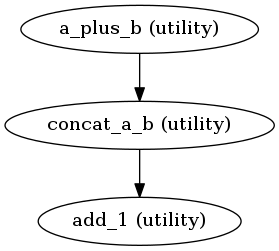

In [13]:
Image("hello_mapnode/graph.dot.png")

And more detailed structure with all nodes:

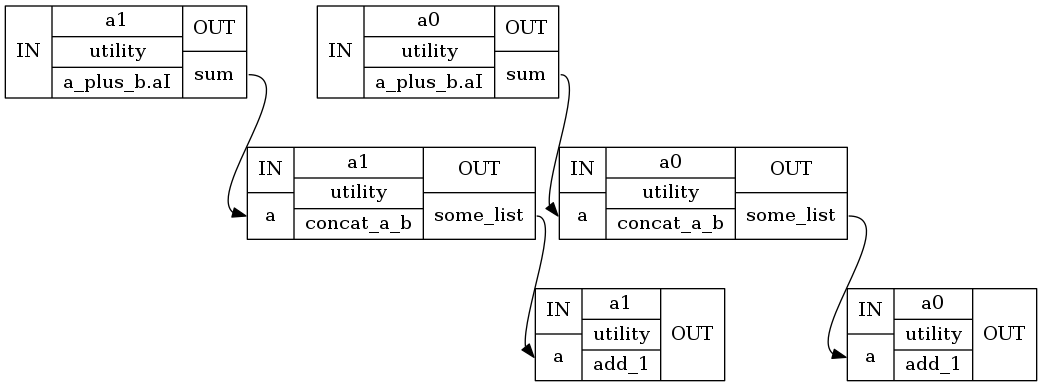

In [14]:
Image("hello_mapnode/graph_detailed.dot.png")

We will introduce another iterables, for the concater Node:

In [15]:
concater.iterables = ('b', [3, 4])
eg = wf.run()
eg.nodes()

170829-12:58:19,594 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170829-12:58:19,643 workflow INFO:
	 Running serially.
170829-12:58:19,645 workflow INFO:
	 Executing node a_plus_b.bI.b1 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/a_plus_b
170829-12:58:19,658 workflow INFO:
170829-12:58:19,669 workflow INFO:
	 Executing node concat_a_b.aI.a0.b1 in dir: /opt/tutorial/notebooks/hello/_a_2/_b_3/concat_a_b
170829-12:58:19,684 workflow INFO:
170829-12:58:19,700 workflow INFO:
	 Executing node add_1.a0.b1 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1
170829-12:58:19,740 workflow INFO:
	 Executing node _add_10 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1/mapflow/_add_10
PLUS ONE, a = 4
170829-12:58:19,847 workflow INFO:
	 Executing node _add_11 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1/mapflow/_add_11
PLUS ONE, a = 3
170829-12:58:19,956 workflow INFO:
	 Executing node concat_a_b.aI.a1.b1 in dir:

[hello_mapnode.a_plus_b.bI.b0,
 hello.concat_a_b.aI.a0.b0,
 hello_mapnode.add_1.a0.b0,
 hello.concat_a_b.aI.a1.b0,
 hello_mapnode.add_1.a1.b0,
 hello_mapnode.a_plus_b.bI.b1,
 hello.concat_a_b.aI.a0.b1,
 hello_mapnode.add_1.a0.b1,
 hello.concat_a_b.aI.a1.b1,
 hello_mapnode.add_1.a1.b1]

In [16]:
wf.write_graph(graph2use='exec')

170829-12:58:24,672 workflow INFO:
	 Generated workflow graph: /opt/tutorial/notebooks/hello_mapnode/graph.dot.png (graph2use=exec, simple_form=True).


'/opt/tutorial/notebooks/hello_mapnode/graph.dot.png'

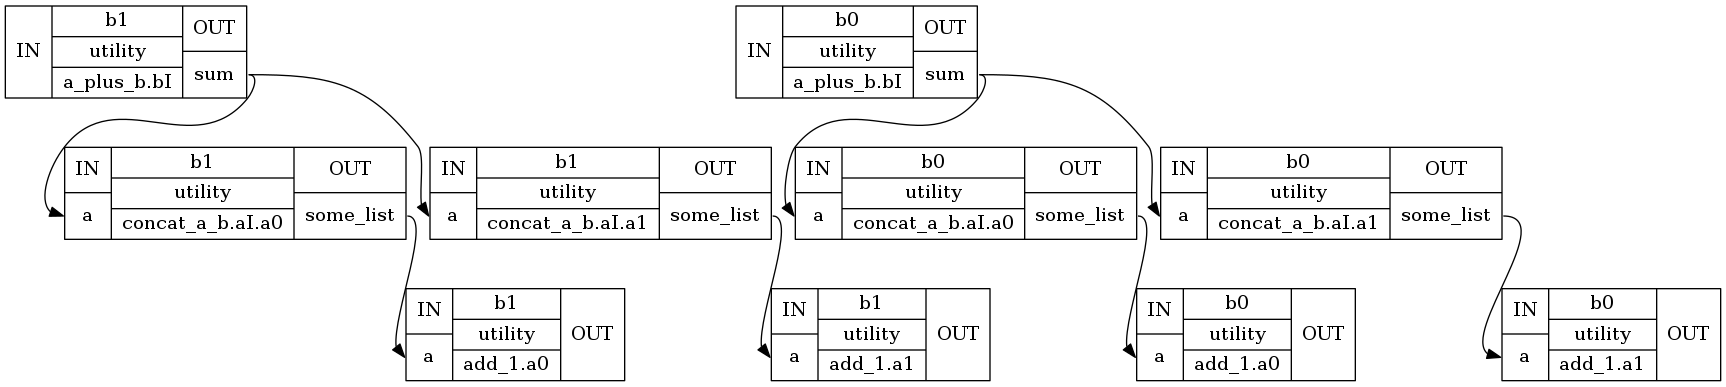

In [17]:
Image("hello_mapnode/graph_detailed.dot.png")

Now we will introduce JoinNode that allows us to merge results together:

In [18]:
def merge_and_scale_data(data2):
    import numpy as np
    return (np.array(data2) * 1000).tolist()


from nipype import JoinNode
joiner = JoinNode(Function(input_names=['data2'],
                          output_names=['data_scaled'],
                          function=merge_and_scale_data),
                 name='join_scale_data',
                 joinsource=adder,
                 joinfield=['data2'])

wf.connect(plusone, 'out', joiner, 'data2')

eg = wf.run()
eg.nodes()

170829-12:58:34,263 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170829-12:58:34,311 workflow INFO:
	 Running serially.
170829-12:58:34,313 workflow INFO:
	 Executing node a_plus_b.bI.b1 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/a_plus_b
170829-12:58:34,328 workflow INFO:
170829-12:58:34,338 workflow INFO:
	 Executing node concat_a_b.aI.a0.b1 in dir: /opt/tutorial/notebooks/hello/_a_2/_b_3/concat_a_b
170829-12:58:34,350 workflow INFO:
170829-12:58:34,363 workflow INFO:
	 Executing node add_1.a0.b1 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1
170829-12:58:34,393 workflow INFO:
	 Executing node _add_10 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1/mapflow/_add_10
PLUS ONE, a = 4
170829-12:58:34,470 workflow INFO:
	 Executing node _add_11 in dir: /opt/tutorial/notebooks/hello_mapnode/_a_2/_b_3/add_1/mapflow/_add_11
PLUS ONE, a = 3
170829-12:58:34,573 workflow INFO:
	 Executing node concat_a_b.aI.a1.b1 in dir:

[hello_mapnode.join_scale_data.a0,
 hello_mapnode.join_scale_data.a1,
 hello_mapnode.a_plus_b.bI.b0,
 hello.concat_a_b.aI.a0.b0,
 hello_mapnode.add_1.a0.b0,
 hello.concat_a_b.aI.a1.b0,
 hello_mapnode.add_1.a1.b0,
 hello_mapnode.a_plus_b.bI.b1,
 hello.concat_a_b.aI.a0.b1,
 hello_mapnode.add_1.a0.b1,
 hello.concat_a_b.aI.a1.b1,
 hello_mapnode.add_1.a1.b1]

Let's check the output of ``hello.join_scale_data.a0`` node:

In [19]:
eg.nodes()[0].result.outputs


data_scaled = [[4000, 4000], [5000, 4000]]

In [20]:
wf.write_graph(graph2use='exec')

170829-12:58:40,477 workflow INFO:
	 Generated workflow graph: /opt/tutorial/notebooks/hello_mapnode/graph.dot.png (graph2use=exec, simple_form=True).


'/opt/tutorial/notebooks/hello_mapnode/graph.dot.png'

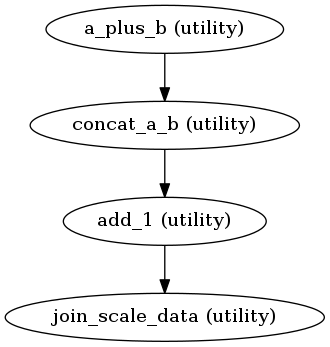

In [21]:
Image("hello_mapnode/graph.dot.png")

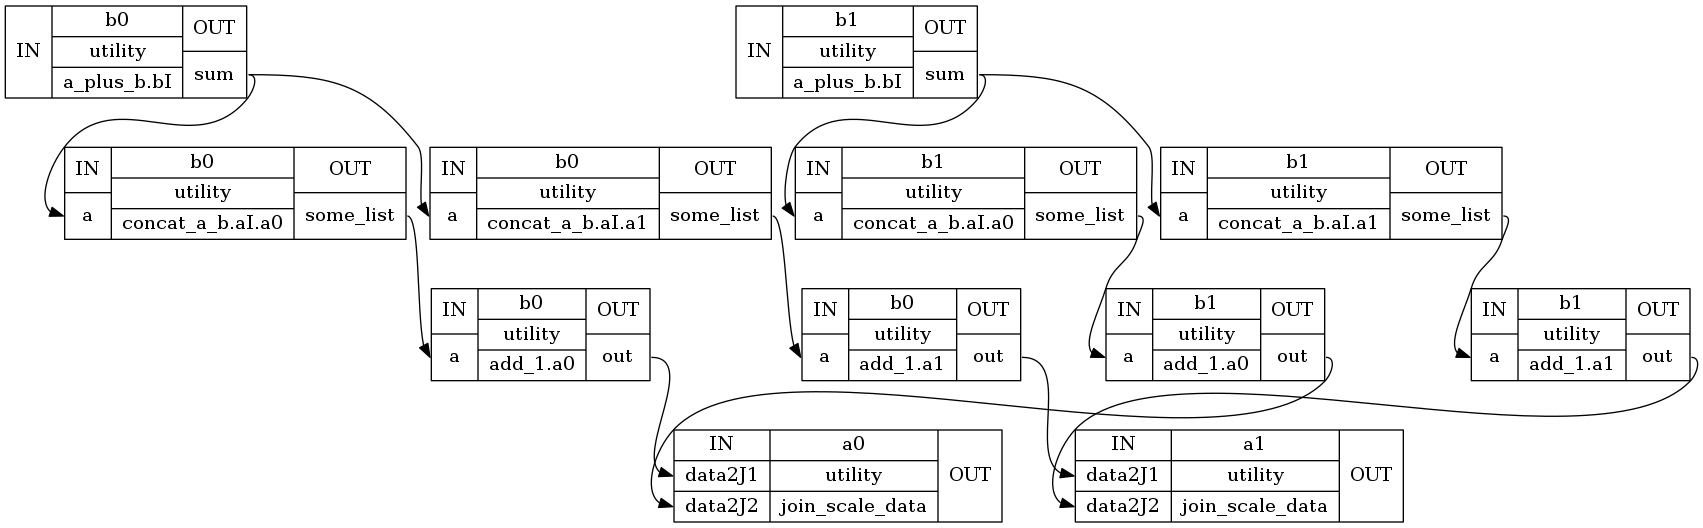

In [22]:
Image("hello_mapnode/graph_detailed.dot.png")

In [23]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

170829-12:58:53,520 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170829-12:58:53,570 workflow INFO:
	 Running in parallel.
170829-12:58:53,577 workflow INFO:
	 Executing: a_plus_b.bI.b1 ID: 0
170829-12:58:53,588 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b1 jobid: 0
170829-12:58:53,592 workflow INFO:
	 Executing: a_plus_b.bI.b0 ID: 5
170829-12:58:53,601 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b0 jobid: 5
170829-12:58:53,606 workflow INFO:
	 Executing: concat_a_b.aI.a0.b1 ID: 1
170829-12:58:53,622 workflow INFO:
	 [Job finished] jobname: concat_a_b.aI.a0.b1 jobid: 1
170829-12:58:53,627 workflow INFO:
	 Executing: concat_a_b.aI.a1.b1 ID: 3
170829-12:58:53,644 workflow INFO:
	 [Job finished] jobname: concat_a_b.aI.a1.b1 jobid: 3
170829-12:58:53,650 workflow INFO:
	 Executing: add_1.a0.b1 ID: 2
170829-12:58:53,666 workflow INFO:
	 Adding 2 jobs for mapnode add_1.a0.b1
170829-12:58:53,674 workflow INFO:
	 Executing: add_1.a1.b1 I

In [24]:
wf.base_dir = os.path.join(os.getcwd(), 'alt')

In [25]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

170829-12:59:01,216 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170829-12:59:01,270 workflow INFO:
	 Running in parallel.
170829-12:59:01,280 workflow INFO:
	 Executing: a_plus_b.bI.b1 ID: 0
170829-12:59:01,297 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b1 jobid: 0
170829-12:59:01,304 workflow INFO:
	 Executing: a_plus_b.bI.b0 ID: 5
170829-12:59:01,315 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b0 jobid: 5
170829-12:59:01,320 workflow INFO:
	 Executing: concat_a_b.aI.a0.b1 ID: 1
170829-12:59:01,339 workflow INFO:
	 [Job finished] jobname: concat_a_b.aI.a0.b1 jobid: 1
170829-12:59:01,342 workflow INFO:
	 Executing: concat_a_b.aI.a1.b1 ID: 3
170829-12:59:01,360 workflow INFO:
	 [Job finished] jobname: concat_a_b.aI.a1.b1 jobid: 3
170829-12:59:01,366 workflow INFO:
	 Executing: add_1.a0.b1 ID: 2
170829-12:59:01,388 workflow INFO:
	 Adding 2 jobs for mapnode add_1.a0.b1
170829-12:59:01,396 workflow INFO:
	 Executing: add_1.a1.b1 I

In [26]:
%time eg = wf.run(plugin='MultiProc', plugin_args={'n_procs': 2})

170829-12:59:27,443 workflow INFO:
	 Workflow hello_mapnode settings: ['check', 'execution', 'logging']
170829-12:59:27,522 workflow INFO:
	 Running in parallel.
170829-12:59:27,533 workflow INFO:
	 Executing: a_plus_b.bI.b1 ID: 0
170829-12:59:27,547 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b1 jobid: 0
170829-12:59:27,553 workflow INFO:
	 Executing: a_plus_b.bI.b0 ID: 5
170829-12:59:27,566 workflow INFO:
	 [Job finished] jobname: a_plus_b.bI.b0 jobid: 5
170829-12:59:27,577 workflow INFO:
	 Executing: concat_a_b.aI.a0.b1 ID: 1
170829-12:59:27,595 workflow INFO:
	 [Job finished] jobname: concat_a_b.aI.a0.b1 jobid: 1
170829-12:59:27,599 workflow INFO:
	 Executing: concat_a_b.aI.a1.b1 ID: 3
170829-12:59:27,625 workflow INFO:
	 [Job finished] jobname: concat_a_b.aI.a1.b1 jobid: 3
170829-12:59:27,631 workflow INFO:
	 Executing: add_1.a0.b1 ID: 2
170829-12:59:27,651 workflow INFO:
	 Adding 2 jobs for mapnode add_1.a0.b1
170829-12:59:27,659 workflow INFO:
	 Executing: add_1.a1.b1 I

### Exercise 1

Create a workflow to calculate a sum of factorials of numbers from a range between $n_{min}$ and $n_{max}$, i.e.:

$$\sum _{k=n_{min}}^{n_{max}} k! = 0! + 1! +2! + 3! + \cdots$$ 

if $n_{min}=0$ and $n_{max}=3$
$$\sum _{k=0}^{3} k! = 0! + 1! +2! + 3!  =  1 + 1 + 2 + 6 = 10$$


In [27]:
from nipype import Workflow, Node, MapNode, Function
import os

def range_fun(n_min, n_max):
    return list(range(n_min, n_max+1))

def factorial(n):
    # print("FACTORIAL, {}".format(n))
    import math
    return math.factorial(n)

def summing(terms):
    return sum(terms)

wf_ex1 = Workflow('ex1')
wf_ex1.base_dir = os.getcwd()

range_nd = Node(Function(input_names=['n_min', 'n_max'],
                         output_names=['range_list'],
                         function=range_fun), 
                name='range_list')

factorial_nd = MapNode(Function(input_names=['n'],
                                output_names=['fact_out'],
                                function=factorial), 
                       iterfield=['n'],
                       name='factorial')

summing_nd = Node(Function(input_names=['terms'],
                           output_names=['sum_out'],
                           function=summing), 
                  name='summing')


range_nd.inputs.n_min = 0
range_nd.inputs.n_max = 3

wf_ex1.add_nodes([range_nd])
wf_ex1.connect(range_nd, 'range_list', factorial_nd, 'n')
wf_ex1.connect(factorial_nd, 'fact_out', summing_nd, "terms")


eg = wf_ex1.run()

170829-12:59:35,43 workflow INFO:
	 Workflow ex1 settings: ['check', 'execution', 'logging']
170829-12:59:35,85 workflow INFO:
	 Running serially.
170829-12:59:35,87 workflow INFO:
	 Executing node range_list in dir: /opt/tutorial/notebooks/ex1/range_list
170829-12:59:35,101 workflow INFO:
170829-12:59:35,117 workflow INFO:
	 Executing node factorial in dir: /opt/tutorial/notebooks/ex1/factorial
170829-12:59:35,141 workflow INFO:
	 Executing node summing in dir: /opt/tutorial/notebooks/ex1/summing
170829-12:59:35,154 workflow INFO:


let's print all nodes:

In [28]:
eg.nodes()

[ex1.range_list, ex1.factorial, ex1.summing]

the final result should be 10:

In [29]:
eg.nodes()[2].result.outputs


sum_out = 10

we can also check the results of two other nodes:

In [30]:
print(eg.nodes()[0].result.outputs)
print(eg.nodes()[1].result.outputs)


range_list = [0, 1, 2, 3]

Bunch(fact_out=[1, 1, 2, 6])


In [31]:
#write your code here

# 1. write 3 functions: one that return a list of number from specific range, 
#    second that returns n! (you can use math.factorial) and third that sums the elements from a list

# 2. create a workflow and define the working directory

# 3. define 3 nodes using Node and MapNode and connect them within the workflow

# 4. run the workflow and check the results


### Exercise 2

Create a workflow to calculate the following sum for chosen $n$ and five different values of $x$:  $0$, $\frac{1}{2} \pi$, $\pi$, $\frac{3}{2} \pi$, and $ 2 \pi$.

$\sum _{{k=0}}^{{n}}{\frac  {(-1)^{k}}{(2k+1)!}}x^{{2k+1}}\quad =x-{\frac  {x^{3}}{3!}}+{\frac  {x^{5}}{5!}}-\cdots $


In [32]:
# we can reuse function from previous exercise, but they need some edits
from nipype import Workflow, Node, MapNode, JoinNode, Function
import os
import math

def range_fun(n_max):
    return list(range(n_max+1))

def term(k, x):
    import math
    fract = math.factorial(2 * k + 1)
    polyn = x ** (2 * k + 1) 
    return (-1)**k * polyn / fract

def summing(terms):
    return sum(terms)

wf_ex2 = Workflow('ex2')
wf_ex2.base_dir = os.getcwd()

range_nd = Node(Function(input_names=['n_max'],
                         output_names=['range_list'],
                         function=range_fun), 
                name='range_list')

term_nd = MapNode(Function(input_names=['k', 'x'],
                           output_names=['term_out'],
                           function=term), 
                  iterfield=['k'],
                  name='term')

summing_nd = Node(Function(input_names=['terms'],
                           output_names=['sum_out'],
                           function=summing), 
                name='summing')


range_nd.inputs.n_max = 15

x_list = [0, 0.5 * math.pi, math.pi, 1.5 * math.pi, 2 * math.pi]

term_nd.iterables = ('x', x_list)

wf_ex2.add_nodes([range_nd])
wf_ex2.connect(range_nd, 'range_list', term_nd, 'k')
wf_ex2.connect(term_nd, 'term_out', summing_nd, "terms")


eg = wf_ex2.run()

170829-12:59:46,176 workflow INFO:
	 Workflow ex2 settings: ['check', 'execution', 'logging']
170829-12:59:46,230 workflow INFO:
	 Running serially.
170829-12:59:46,231 workflow INFO:
	 Executing node range_list in dir: /opt/tutorial/notebooks/ex2/range_list
170829-12:59:46,243 workflow INFO:
170829-12:59:46,252 workflow INFO:
	 Executing node term.aI.a0 in dir: /opt/tutorial/notebooks/ex2/_x_0/term
170829-12:59:46,276 workflow INFO:
	 Executing node summing.a0 in dir: /opt/tutorial/notebooks/ex2/_x_0/summing
170829-12:59:46,350 workflow INFO:
	 Executing node term.aI.a1 in dir: /opt/tutorial/notebooks/ex2/_x_1.5707963267948966/term
170829-12:59:46,371 workflow INFO:
	 Executing node summing.a1 in dir: /opt/tutorial/notebooks/ex2/_x_1.5707963267948966/summing
170829-12:59:46,436 workflow INFO:
	 Executing node term.aI.a2 in dir: /opt/tutorial/notebooks/ex2/_x_3.141592653589793/term
170829-12:59:46,456 workflow INFO:
	 Executing node summing.a2 in dir: /opt/tutorial/notebooks/ex2/_x_3.1

let's check all nodes

In [33]:
eg.nodes()

[ex2.range_list,
 ex2.term.aI.a0,
 ex2.summing.a0,
 ex2.term.aI.a1,
 ex2.summing.a1,
 ex2.term.aI.a2,
 ex2.summing.a2,
 ex2.term.aI.a3,
 ex2.summing.a3,
 ex2.term.aI.a4,
 ex2.summing.a4]

let's print all results of ``ex2.summing``

In [34]:
print(eg.nodes()[2].result.outputs)
print(eg.nodes()[4].result.outputs)
print(eg.nodes()[6].result.outputs)
print(eg.nodes()[8].result.outputs)
print(eg.nodes()[10].result.outputs)


sum_out = 0.0


sum_out = 1.0000000000000002


sum_out = 3.328027611925569e-16


sum_out = -1.0000000000000022


sum_out = -2.4376365177316827e-11



Great, we just implemented pretty good Sine function! Those number should be approximately 0, 1, 0, -1 and 0. If they are not, try to increase $n_max$.

In [35]:
# write your solution here

# 1. write 3 functions: one that return a list of number from a range between 0 and some n, 
#    second that returns a term for a specific k, and third that sums the elements from a list

# 2. create a workflow and define the working directory

# 3. define 3 nodes using Node and MapNode and connect them within the workflow

# 4. use iterables for 4 values of x

# 5. run the workflow and check the final results for every value of x


### Exercise 2a

Use JoinNode to combine results from Exercise 2 in one container, e.g. a dictionary, that takes value $x$ as a key and the result from ``summing`` Node as a value.

In [36]:
def merge_results(results, x):
    return dict(zip(x, results))

join_nd = JoinNode(Function(input_names=['results', 'x'],
                            output_names=['results_cont'],
                            function=merge_results),
                   name='merge',
                   joinsource=term_nd, # this is the node that used iterables for x
                   joinfield=['results'])

# taking the list of arguments from the previous part 
join_nd.inputs.x = x_list

# connecting a new node to the summing_nd
wf_ex2.connect(summing_nd, "sum_out", join_nd, "results")

eg = wf_ex2.run()

170829-12:59:53,494 workflow INFO:
	 Workflow ex2 settings: ['check', 'execution', 'logging']
170829-12:59:53,548 workflow INFO:
	 Running serially.
170829-12:59:53,551 workflow INFO:
	 Executing node range_list in dir: /opt/tutorial/notebooks/ex2/range_list
170829-12:59:53,571 workflow INFO:
170829-12:59:53,582 workflow INFO:
	 Executing node term.aI.a0 in dir: /opt/tutorial/notebooks/ex2/_x_0/term
170829-12:59:53,610 workflow INFO:
	 Executing node summing.a0 in dir: /opt/tutorial/notebooks/ex2/_x_0/summing
170829-12:59:53,707 workflow INFO:
	 Executing node term.aI.a1 in dir: /opt/tutorial/notebooks/ex2/_x_1.5707963267948966/term
170829-12:59:53,733 workflow INFO:
	 Executing node summing.a1 in dir: /opt/tutorial/notebooks/ex2/_x_1.5707963267948966/summing
170829-12:59:53,806 workflow INFO:
	 Executing node term.aI.a2 in dir: /opt/tutorial/notebooks/ex2/_x_3.141592653589793/term
170829-12:59:53,830 workflow INFO:
	 Executing node summing.a2 in dir: /opt/tutorial/notebooks/ex2/_x_3.1

let's print all nodes

In [37]:
eg.nodes()

[ex2.range_list,
 ex2.merge,
 ex2.term.aI.a0,
 ex2.summing.a0,
 ex2.term.aI.a1,
 ex2.summing.a1,
 ex2.term.aI.a2,
 ex2.summing.a2,
 ex2.term.aI.a3,
 ex2.summing.a3,
 ex2.term.aI.a4,
 ex2.summing.a4]

and results from ``merge`` Node:

In [38]:
eg.nodes()[1].result.outputs


results_cont = {0: 0.0, 1.5707963267948966: 1.0000000000000002, 3.141592653589793: 3.328027611925569e-16, 4.71238898038469: -1.0000000000000022, 6.283185307179586: -2.4376365177316827e-11}

In [39]:
# write your code here

# 1. create an additional function that takes 2 list and combines them into one container, e.g. dictionary

# 2. use JoinNode to define a new node that merge results from Exercise 2 and connect it to the workflow

# 3. run the workflow and check the results of the merging node